We plot the histograms of the eigenvalues

In [1]:
import torch
import os
import json
import re
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as colors
import importlib.util
from matplotlib.lines import Line2D
import perturbed_organics.utils as utils


# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
input_type = 'delocalized'
mu = "0.0"
mu_val = float(mu)
# input_scale = "linear"
input_scale = "log-scale"

folder_path = f'/vast/sr6364/perturbed_organics/data/adaptive_main_eigval/{input_type}/'

In [3]:
# This dictionary will map each tensor name (file name without .pt)
# to a dictionary that maps deltaval values to the loaded tensor.
all_data = {}

# Regular expression to capture a deltaval value at the end of the folder name.
# For example, if the folder name is "commonText_deltaval_1.0",
# this regex extracts "1.0".
# pattern = re.compile(r'_delta_([0-9\.]+)$')

pattern = re.compile(
    r'^(?=.*_mu_{})'
    r'.*_delta_([0-9\.]+)_{}$'.format(re.escape(mu), re.escape(input_scale))
)

# delta_vals = [0.05, 0.08, 0.09, 0.166, 0.25, 0.3, 0.35, 0.45, 0.5]
# delta_vals = [0.05, 0.5]


# delta_pattern = "|".join(re.escape(str(delta)) for delta in delta_vals)

# pattern = re.compile(
#     r'^(?=.*_mu_{})'
#     r'.*_delta_({})_{}$'.format(re.escape(mu), delta_pattern, re.escape(input_scale))
# )


representative_subfolder = None
# Loop over all items in the main folder
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        match = pattern.search(subfolder)
        if match:
            representative_subfolder = subfolder
            # Convert the captured deltaval string to a float
            deltaval = float(match.group(1))
            
            # Loop over each file in the subfolder
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.pt'):
                    # Use the file name without the extension as the tensor name
                    tensor_name = os.path.splitext(filename)[0]
                    # Load the torch tensor from file
                    tensor = torch.load(os.path.join(subfolder_path, filename))
                    
                    # If this tensor name has not been seen before, create a new dictionary for it.
                    if tensor_name not in all_data:
                        all_data[tensor_name] = {}
                    
                    # Save the tensor in the inner dictionary with deltaval as key.
                    all_data[tensor_name][deltaval] = tensor

In [4]:
param_file_path = os.path.join(folder_path, representative_subfolder, 'parameters.json')
with open(param_file_path, 'r') as f:
    params = json.load(f)

# Extract parameters
N = params['N']
num_tasks = params['num_tasks']
num_delta = params['num_delta']
num_input = params['num_input']
num_trials = params['num_trials']
delta_range = np.array(params['delta_range'])
input_range = np.array(params['input_range'])

In [5]:
actual_fp_y_dict = all_data['actual_fixed_point_y']
norm_fp_y_dict = all_data['norm_fixed_point_y']
eigvals_dict = all_data['eigvals_J']
condition = all_data['condition']

In [6]:
actual_fp_y_dict.keys()

dict_keys([0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5])

In [8]:
condition_to_check = condition[0.09]

unique_vals, counts = torch.unique(condition_to_check, return_counts=True)
total_entries = condition_to_check.numel()  # Total number of elements

# Calculate percentage for each unique value
percentages = (counts.float() / total_entries) * 100

# Print unique values and their percentages
for val, pct in zip(unique_vals, percentages):
    print(f"Value {val.item()}: {pct.item():.2f}%")

Value 0: 0.37%
Value 2: 99.63%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


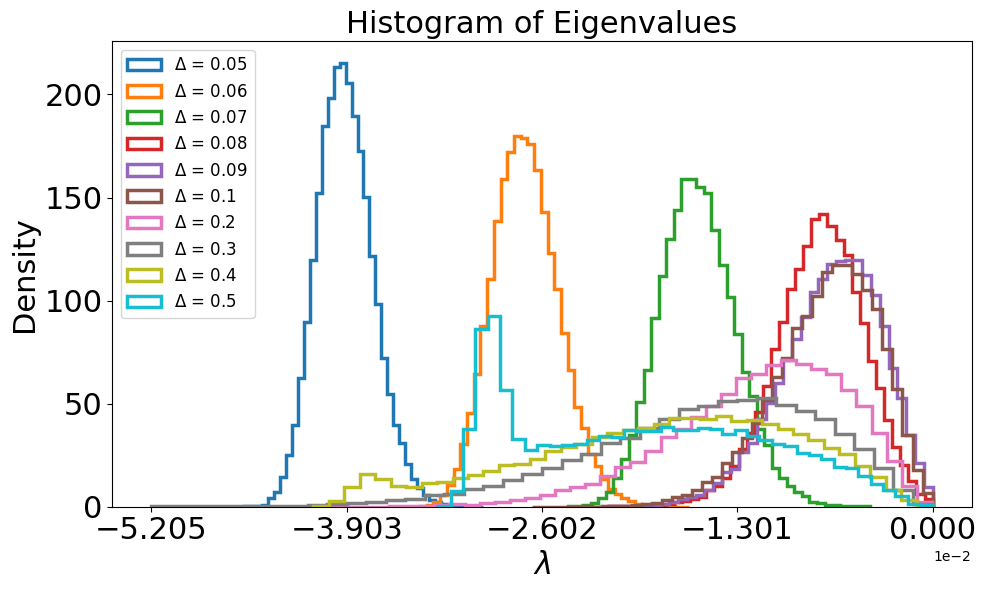

In [16]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))

# Define the delta values
# delta_vals = [0.05, 0.08]  # Extend this list as needed
# delta_vals = sorted(eigvals_dict.keys())
delta_vals = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]

# To compute global x-limits across histograms, we store the min and max values
global_min = float('inf')
global_max = float('-inf')

for delta_val in delta_vals:
    # Retrieve the eigenvalues for the current delta_val
    eigvals = eigvals_dict[delta_val]
    
    # Compute the max real parts scaled by 0.002
    max_real_each_trial = torch.max(eigvals.real, dim=3)[0] * 0.002
    
    # Use a specific z index
    z_idx = 0
    
    # Extract the data for the first trial and given z index
    max_real_each_trial_input = max_real_each_trial[0, z_idx, :]
    
    # Remove positive values by keeping only non-positive values
    max_real_each_trial_input = max_real_each_trial_input[max_real_each_trial_input <= 0]
    
    # Convert data to numpy array for further operations
    data = max_real_each_trial_input.cpu().numpy()
    
    # Update global min and max for x-axis ticks
    global_min = min(global_min, data.min())
    global_max = max(global_max, data.max())
    
    # Plot the line histogram (using histtype='step') with a thicker line
    plt.hist(data, bins=40, density=True, histtype='step', linewidth=2.5,
             label=f"$\\Delta$ = {delta_val}")

# Set labels and title
plt.xlabel(r"$\lambda$", fontsize=22)
plt.ylabel('Density', fontsize=22)
plt.title("Histogram of Eigenvalues", fontsize=22)

# Create 5 ticks between the global min and 0, ensuring 0 is included
ticks = np.linspace(global_min, 0, 5)
ticks = np.sort(np.unique(np.concatenate((ticks, [0]))))
plt.xticks(ticks, fontsize=22)
plt.yticks(fontsize=22)

# Set x-axis to scientific notation using ScalarFormatter
ax = plt.gca()
formatter = ticker.ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
ax.xaxis.set_major_formatter(formatter)

# Add a legend to differentiate the histograms
plt.legend(fontsize=12)

folder_loc = f'../figures/mu_{mu}/fig_histogram'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'histogram'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()

plt.show()
